In [1]:
import scipy.io

mat = scipy.io.loadmat("../datasets/rit18_data.mat")


In [2]:
train_data = mat["train_data"].transpose(1,2,0)
train_labels = mat["train_labels"]
val_data = mat["val_data"].transpose(1,2,0)
val_labels = mat["val_labels"]
test_data = mat["test_data"].transpose(1,2,0)

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
np.histogram(train_labels, bins = 19)

(array([13782516,   154048,  6065240,   177727,    43915,     1635,
            2763,    10677,      974,     1170,      841,      893,
          496681,   581649, 11947603,  7935955,  6452081,   956152,
         4382786]),
 array([ 0.        ,  0.94736842,  1.89473684,  2.84210526,  3.78947368,
         4.73684211,  5.68421053,  6.63157895,  7.57894737,  8.52631579,
         9.47368421, 10.42105263, 11.36842105, 12.31578947, 13.26315789,
        14.21052632, 15.15789474, 16.10526316, 17.05263158, 18.        ]))

In [ ]:
h

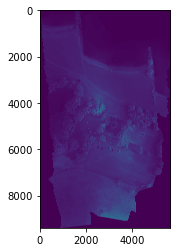

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_data[:,:,3])

In [29]:
from unet import u_net
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d

train_data_patches = extract_patches_2d(train_data, (512, 512), max_patches = 0.000002, random_state = 1)
train_labels_patches = extract_patches_2d(train_labels, (512, 512), max_patches=0.000002, random_state = 1)

# Saving data patches
for i in range(len(train_data_patches)):
    np.save(f"data_rit18/train_data/image_file_{i}.npy", train_data_patches[i])
    np.save(f"data_rit18/train_data/label_file_{i}.npy", train_labels_patches[i])

# Data augmentation : Saving flipped patches
for i in range(len(train_data_patches)):
    if np.random.uniform() > 0.5 : 
        np.save(f"data_rit18/train_data/image_file_{len(train_data_patches) + i}.npy", np.flip(train_data_patches[i], 0))
        np.save(f"data_rit18/train_data/label_file_{len(train_labels_patches) + i}.npy", np.flip(train_labels_patches[i], 0))
    else :
        np.save(f"data_rit18/train_data/image_file_{len(train_data_patches) + i}.npy", np.flip(train_data_patches[i], 1))
        np.save(f"data_rit18/train_data/label_file_{len(train_labels_patches) + i}.npy", np.flip(train_labels_patches[i], 0))
        

# Remove patches from memory

del train_data_patches
del train_labels_patches

In [9]:
from keras.optimizers import Adam
from keras import backend as K

def jaccard2_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
def jaccard2_loss(y_true, y_pred, smooth=1.0):
    return 1 - jaccard2_coef(y_true, y_pred, smooth)

In [74]:
from tensorflow.keras.utils import Sequence

# A data generator to load images per batches in order to avoid loading all the images at once and overload the RAM. 

all_files_loc = "data_rit18/train_data"
all_files = os.listdir(all_files_loc)

image_label_map = {
        "image_file_{}.npy".format(i): "label_file_{}.npy".format(i)
        for i in range(len(all_files)//2) }
partition = [item for item in all_files if "image_file" in item]



class DataGenerator(Sequence):

    def __init__(self, file_list):
        """Constructor can be expanded,
           with batch size, dimentation etc.
        """
        self.file_list = file_list
        self.on_epoch_end()

    def __len__(self):
      'Take all batches in each iteration'
      return int(len(self.file_list))

    def __getitem__(self, index):
      'Get next batch'
      # Generate indexes of the batch
      indexes = self.indexes[index:(index+32)]

      # single file
      file_list_temp = [self.file_list[k] for k in indexes]

      # Set of X_train and y_train
      X, y = self.__data_generation(file_list_temp)

      return X, y

    def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.file_list))

    def __data_generation(self, file_list_temp):
      'Generates data containing batch_size samples'
      data_loc = "data_rit18/train_data"
      # Generate data
      X_r = []
      y_r = []
      for ID in file_list_temp:
          x_file_path = data_loc + "/" + ID
          y_file_path = data_loc + "/" + image_label_map.get(ID)

          # Store sample
          X = np.load(x_file_path)
          X_r.append(X)

          # Store class
          y = np.load(y_file_path)
          y_r.append(y)
    
      return np.array(X_r), np.array(y_r)




In [75]:
# ====================
# train set
# ====================
all_files_loc = "data_rit18/train_data"
all_files = os.listdir(all_files_loc)
partition = [item for item in all_files if "image_file" in item]

training_generator = DataGenerator(partition)


In [80]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [85]:
#validation_generator = ValDataGenerator(val_partition) # work same as training generator
from unet import u_net 

model = u_net((512, 512, 7), output_channels=18)
model.compile(loss = jaccard_distance_loss, optimizer=Adam())


X, y = training_generator.__getitem__(0)
print(X.shape, y.shape)

hst = model.fit(X, y[0], batch_size = 1)

(32, 512, 512, 7) (32, 512, 512)


ValueError: Data cardinality is ambiguous:
  x sizes: 32
  y sizes: 512
Please provide data which shares the same first dimension.

In [23]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os



model = u_net((512, 512, 7), output_channels=18)
model.compile(loss=jaccard2_loss, optimizer=Adam())

image_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, dtype=None)
mask_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, dtype=None)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
# image_datagen.fit(train_data, augment=True, seed=seed)
# mask_datagen.fit(train_labels, augment=True, seed=seed)
print("a")
data_generator = image_datagen.flow_from_directory("data_rit18/train_data",
        class_mode=None,
        seed=seed)
mask_generator = mask_datagen.flow_from_directory("data_rit18/train_labels",
    class_mode=None,
    seed=seed)

print("b")
train_generator = zip(data_generator, mask_generator)

model.fit(train_generator, batch_size=16, 
            steps_per_epoch=len(os.listdir("data_rit18/train_data")) / 16, epochs=1)


a
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
b


InvalidArgumentError:  input depth must be evenly divisible by filter depth: 3 vs 7
	 [[node model_6/conv1_1/Conv2D (defined at <ipython-input-23-20b06caf3a41>:25) ]] [Op:__inference_train_function_9527]

Function call stack:
train_function


In [8]:
import tensorflow as tf
cce = tf.keras.losses.SparseCategoricalCrossentropy()

In [18]:
y_true = [0]
y_pred = [[0.0, 1.0, 0]]
# Using 'auto'/'sum_over_batch_size' reduction type.  
scce = tf.keras.losses.SparseCategoricalCrossentropy()
scce(y_true, y_pred).numpy()

16.811243

In [1]:
import scipy.io
from sklearn.feature_extraction.image import extract_patches_2d
from unet import u_net 


mat = scipy.io.loadmat("../datasets/rit18_data.mat")


# Extracting training data from the mat dictionnary-----------------------------
print("Extracting training data from the mat dictionnary")

train_data = mat["train_data"].transpose(1,2,0)

Extracting training data from the mat dictionnary


In [2]:
del mat

In [3]:
train_data_patches = extract_patches_2d(train_data, (256, 256), max_patches = 0.00001, random_state = 1)


In [4]:
del train_data

In [5]:
import numpy as np

indexes = []
for i in range(len(train_data_patches)):
    print(i)
    if np.count_nonzero(train_data_patches[i])/(len(train_data_patches[i].flatten())) == 1.0: 
        indexes.append(i)
train_data_patches = np.delete(train_data_patches, indexes)
train_labels_patches = np.delete(train_labels_patches, indexes)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
print(len(indexes))

332


In [4]:
import scipy.io
from sklearn.feature_extraction.image import extract_patches_2d
from unet import u_net 
import numpy as np

mat = scipy.io.loadmat("../datasets/rit18_data.mat")


# Extracting training data from the mat dictionnary-----------------------------
print("Extracting training data from the mat dictionnary")

train_data = mat["train_data"].transpose(1,2,0)
train_labels = mat["train_labels"]

val_data = mat["val_data"].transpose(1,2,0)
val_labels = mat["val_labels"]

del mat

# Generating patches from the big image------------------------------------------
print("Generating patches from the big image")
train_data_patches = extract_patches_2d(train_data, (128, 128), max_patches = 0.00001, random_state = 1)
train_labels_patches = extract_patches_2d(train_labels, (128, 128), max_patches=0.00001, random_state = 1)

val_data_patches = extract_patches_2d(val_data, (128, 128), max_patches = 0.00001, random_state = 1)
val_labels_patches = extract_patches_2d(val_labels, (128, 128), max_patches=0.00001, random_state = 1)

del train_data
del train_labels
del val_data
del val_labels

# Removing dark patches taken from the borders of the dataset

indexes = []
for i in range(len(train_data_patches)):
    print(i)
    if np.count_nonzero(train_data_patches[i])/(len(train_data_patches[i].flatten())) != 1.0: 
        indexes.append(i)
train_data_patches = np.delete(train_data_patches, indexes, axis = 0)
train_labels_patches = np.delete(train_labels_patches, indexes, axis = 0)

indexes = []
for i in range(len(train_data_patches)):
    if np.count_nonzero(train_data_patches[i])/(len(train_data_patches[i].flatten())) != 1.0: 
        indexes.append(i)
val_data_patches = np.delete(val_data_patches, indexes, axis = 0)
val_labels_patches = np.delete(val_labels_patches, indexes, axis = 0)

del indexes

Extracting training data from the mat dictionnary
Generating patches from the big image
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
25

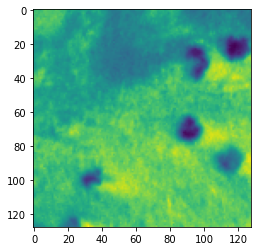

In [7]:
import matplotlib.pyplot as plt

plt.imshow(train_data_patches[1][:,:,2])

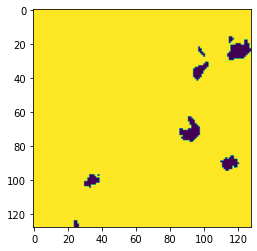

In [8]:
plt.imshow(train_labels_patches[1])

In [1]:
import scipy.io
from sklearn.feature_extraction.image import extract_patches_2d
from unet import u_net 
import numpy as np

mat = scipy.io.loadmat("../datasets/rit18_data.mat")


# Extracting training data from the mat dictionnary-----------------------------
print("Extracting training data from the mat dictionnary")

train_data = mat["train_data"].transpose(1,2,0)
train_labels = mat["train_labels"]

val_data = mat["val_data"].transpose(1,2,0)
val_labels = mat["val_labels"]

del mat

# Generating patches from the big image------------------------------------------
print("Generating patches from the big image")
train_data_patches = extract_patches_2d(train_data, (128, 128), max_patches = 0.00005, random_state = 1)
train_labels_patches = extract_patches_2d(train_labels, (128, 128), max_patches=0.00005, random_state = 1)

val_data_patches = extract_patches_2d(val_data, (128, 128), max_patches = 0.00005, random_state = 1)
val_labels_patches = extract_patches_2d(val_labels, (128, 128), max_patches=0.00005, random_state = 1)

del train_data
del train_labels
del val_data
del val_labels

# Removing dark patches taken from the borders of the dataset

indexes = []
for i in range(len(train_data_patches)):
    print(i)
    if np.count_nonzero(train_data_patches[i])/(len(train_data_patches[i].flatten())) != 1.0: 
        indexes.append(i)
train_data_patches = np.delete(train_data_patches, indexes, axis = 0)
train_labels_patches = np.delete(train_labels_patches, indexes, axis = 0)

indexes = []
for i in range(len(val_data_patches)):
    if np.count_nonzero(val_data_patches[i])/(len(val_data_patches[i].flatten())) != 1.0: 
        indexes.append(i)
val_data_patches = np.delete(val_data_patches, indexes, axis = 0)
val_labels_patches = np.delete(val_labels_patches, indexes, axis = 0)

del indexes


print("Number of patches :", train_data_patches.shape, train_labels_patches.shape)


# Defining the Jaccard-Loss------------------------------------------------------
print("Defining the Jaccard-Loss")

from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from keras import backend as K

def jaccard2_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)
def jaccard2_loss(y_true, y_pred, smooth=1.0):
    return 1 - jaccard2_coef(y_true, y_pred, smooth)

# Creating the model--------------------------------------------------------------
print("Creating the model")

model = u_net((128, 128, 7), output_channels=19, activation="sigmoid")
model.compile(loss = "sparse_categorical_crossentropy", optimizer=Adam())

print("Fitting the model")
model.fit(train_data_patches, train_labels_patches, batch_size=64, 
            steps_per_epoch=len(train_data_patches) / 64, epochs=5, validation_data = (val_data_patches, val_labels_patches))


Extracting training data from the mat dictionnary
Generating patches from the big image
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
25

In [3]:
y_pred = model.predict(val_data_patches[:32])

In [7]:
y_pred[0].argmax(axis=2).shape

(128, 128)

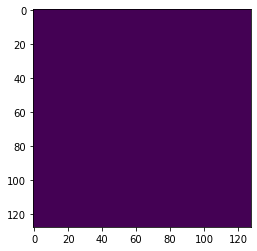

In [31]:
import matplotlib.pyplot as plt
plt.imshow(y_pred[3].argmax(axis=2))

In [18]:
y_pred[3, 1,1]

array([0.08121213, 0.03851145, 0.759004  , 0.11395255, 0.09000061,
       0.04134637, 0.03097462, 0.06313111, 0.05905617, 0.0595987 ,
       0.04414747, 0.06598735, 0.15000473, 0.09896485, 0.9313539 ,
       0.90470546, 0.7912883 , 0.13646954, 0.53814465], dtype=float32)

In [38]:
val_data_patches[0][:,:,7].nonzer

IndexError: index 7 is out of bounds for axis 2 with size 7